In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.mp.linear import LinearExpr
import import_ipynb
import Methods as mt
%matplotlib inline

importing Jupyter notebook from Methods.ipynb


In [151]:
#Leitura das Instâncias
veiculos = pd.read_csv("k_50",index_col=0)
vitimas = pd.read_csv("v_15",index_col=0)
pontos = pd.read_csv("n_300",index_col=0)
hospitais = veiculos["Inicial"].unique()

In [152]:
#Criação da Matriz de Distância
_DistanceMatrix = pd.read_csv("d_300")

# Modelagem

In [153]:
vrp = Model("Ambulancias-VRP") #Modelo

In [ ]:
#Matriz com as variáveis de decisão principais
_DecisionCube = vrp.binary_var_cube(_DistanceMatrix.index,_DistanceMatrix.index,veiculos.index,"Arc")

In [ ]:
#Função Objetivo
vrp.minimize(vrp.sum(_DecisionCube[i,j,k]*_DistanceMatrix.loc[i][j] 
                     for i in _DistanceMatrix.index 
                     for j in _DistanceMatrix.index 
                     for k in veiculos.index))

In [ ]:
forbidden = LinearExpr(vrp)   #Arcos proíbidos

for k in veiculos.index:
    for i in _DistanceMatrix.index:
        
        flux = LinearExpr(vrp)    #Conservação de Fluxo
        match = LinearExpr(vrp)   #Restrição de Compatibilidade
        for j in _DistanceMatrix.index:
            
            if _DistanceMatrix.loc[i][j] > 0:    #Verifica se o arco existe
                
                if i in vitimas["Ponto"].values: #Se nodo 'i' for uma vítima:
                    match+=_DecisionCube[j,i,k]  #Adiciona os arcos 'jik' em 'match'
                    flux +=_DecisionCube[j,i,k]  #Subtrai o arco de chegada em 'i'
                
                elif i == veiculos.loc[k]["Inicial"]: #Se o nodo 'i' for um hospital
                    flux += _DecisionCube[i,j,k]      #Adiciona o arco de saída de 'i'
                
                elif j == veiculos.loc[k]["Inicial"]: #Se o nodo 'j' for o ponto de saida de 'k'
                    forbidden += _DecisionCube[i,j,k] #Retira o arco 'ij' da solução
                    flux -=_DecisionCube[j,i,k]       #Coloca o arco de saída de 'j' no fluxo
                    
                else:                                 #Se nenhum desses casos se aplicar
                    flux+=_DecisionCube[i,j,k]-_DecisionCube[j,i,k] #Fluxo normal
                
                    
            else:                               #Se o arco não existir
                forbidden += _DecisionCube[i,j,k]#Tira ele da solução
                         
        if i in vitimas["Ponto"].values: #Se nodo 'i' for uma vítima
            #Permite 'k' chegar em 'i' no máximo 1 vez
            vrp.add_constraint(flux<=1,"ChegadaVitima_"+str(i)+"_Carro_"+str(k))
            
            #Pega a prioridade da vitima 'i'
            prioridade = vitimas[vitimas["Ponto"] == i]["Prioridade"].values[0]
            
            #E cria as restriçõe de UpperBound
            vrp.add_constraint((veiculos.loc[k]["UpperBound"])*match-prioridade*match>=0,
                               "MatchUB_Ocurrence_"+str(i)+"_Vehicle"+str(k))
            #E LowerBound
            vrp.add_constraint((veiculos.loc[k]["LowerBound"])*match-prioridade*match<=0,
                              "MatchLB_Ocurrence_"+str(i)+"_Vehicle"+str(k))
       
        elif i == veiculos.loc[k]["Inicial"]: #Se o nodo 'i' for o inicial do veiculo 'k'
            #Permite 'k' sair de 'i' no máximo 1 vez
            vrp.add_constraint(flux<=1,"FluxoInicialVeiculo_"+str(k))
        else:
            #Fluxo Normal
            vrp.add_constraint(flux==0,"Fluxo_"+str(i)+"_Carro_"+str(k))

#Eliminação dos arcos inválidos
vrp.add_constraint(forbidden==0,"Cuts");

In [10]:
for k in veiculos.index:
    
    inicial = veiculos.loc[k]["Inicial"] #Ponto de Saída de 'k'
    
    flux_inicial = LinearExpr(vrp) #Fluxo de Saída de 'k'
    
    for i in pontos.loc[inicial][2:].values:          #Para todos os arcos saindo do inicial
        flux_inicial+=_DecisionCube[inicial,int(i),k] #Adicione-os ao fluxo de saída
    
    flux_final = LinearExpr(vrp) #Fluxo de Chegada nas ocorrências
    
    for i in vitimas["Ponto"].values:          #Para todas as ocorrências
        for j in pontos.loc[i][2:]:            #Para todos os arcos saindo delas
            flux_final += _DecisionCube[j,i,k] #Adicione-os ao fluxo de chegada
            
    #Se o veículo sair de seu ponto inicial, ele deve atender uma ocorrência
    vrp.add_constraint(flux_inicial-flux_final==0,"AtendimentoObrigatorio_"+str(k))

In [11]:
for i in vitimas["Ponto"].values:
    
    demand = LinearExpr(vrp) #Demanda da vítima 'i'
    
    for j in pontos.loc[i][2:].values:
        for k in veiculos.index:
            #Para cada arco 'j' chegando em 'i' e veículo 'k'
            #Os adicionamos à expressão
            demand+=_DecisionCube[int(j),int(i),k]
    #Ao menos um precisa passar nessa vítima
    vrp.add_constraint(demand>=1,"DemandaVitima_"+str(i))

In [12]:
for k in veiculos.index:
    capacidade = LinearExpr(vrp) #Capacidade do veículo 'k'
    for i in vitimas["Ponto"].values:
        for j in pontos.loc[i][2:]:
            #Para cada arco chegando em cada vítima
            #Adicione-o à expressão
            capacidade+=_DecisionCube[int(j),int(i),k]
            
    #O veículo só pode 
    vrp.add_constraint(capacidade<=1,"CapacidadeVeiculo_"+str(k))

In [13]:
import time
start = time.time() #Tempo de ínicio
subcicle = True     #Condição de parada
#Assumindo que existe subciclos, nós...
while subcicle == True:
    
    #Rota percorrida por cada veículo
    routes = {x:{} for x in veiculos.index}    
    #{
    #Veículo1:{}
    #Veículo2:{}
    #...
    #VeículoK:{}
    #}
    
    #Solução VRP - Dicionário Desordenado
    _Solution = vrp.solve(log_output=True).as_dict()
    #saida veículo
    #    |   |
    #    v   v
    #Arc_i_j_k: True/False <-Valores Possíveis
    #      ^
    #      |
    #   chegada
    #
    #Arc_i_j_k = Chave
    
    for i in _Solution:
        #
        #
        #"Arc_i_j_k"
        #     |   
        #     v                      0   1   2
        aux = i.split("_")[1:] #<- ["i","j","k"]
        #        ^
        #        |
        #["Arc","i","j","k"]
        #
        #         veiculo=k    saida=i      chegada=j
        #             |            |            |
        #             v            v            v
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        # ^
        # |_ Rotas agrupadas por veículo
            
    count = 0 #Contador para as eliminações de subciclo
    summ = 0 #Condição de parada
    
    #O trecho de código abaixo deve remover o caminho
    #principal para futuramente verificarmos se existe
    #algum subciclo na rota do veículo 'k'
    for k in veiculos.index:
        
        #Primeiramente, verificamos se o veículo 'k'
        #percorreu, ou não, pelo menos um arco
        if len(routes[k]) > 0:
            
            #Se ele percorreu pelo menos um arco:
            #Começamos verificando qual o ponto de saida
            #do veículo 'k' e atribuímos esse nodo para
            #o ponto de partida do nosso loop
            
            inicial = veiculos.loc[k]["Inicial"]
            #  ^
            #  |
            #Saída de 'k'
            #
            #Chegada de 'k'
            #saindo do ponto
            #inicial
            #  |
            #  v
            actual_node = routes[k].pop(inicial)
            
            #inicial->actual_node = primeiro arco de todas as rotas
            
            #Iremos percorrer a rota até que alcançemos a vítima
            while actual_node not in vitimas["Ponto"].values:
                # actual_node                actual_node
                #vira chegada do        inicia como saída do
                #  arco                        arco
                #   |                            |
                #   v                            v
                actual_node = routes[k].pop(actual_node)
                
                #it0: actual_node-> nodo 'j'
                #               ^
                #               |
                #it1:     actual_node -> nodo 'k'
                #                             ^
                #                             |
                #it2:                     actual_node -> nodo 'l' ...
        
        
        #Se sobrou algum subciclo
        #depois da remoção do caminho
        #principal então 
        #len(routes[k]) > 0
        summ += len(routes[k])
        
        
        #Se sobrou algum arco dentro
        #da rota, então deve ser algum
        #subciclo que devemos retirar
        if len(routes[k]) >0:
            
            #Enquanto ainda existir algum arco
            #dentro da rota do veículo 'k'
            #ele faz parte de um subciclo
            #que deve ser retirado, portanto
            #iteramos até removermos todos os
            #subciclos
            while(len(routes[k])>0):
                
                cut = LinearExpr(vrp) #Expressão Linear do Subciclo atual
                
                first_node = list(routes[k].keys())[0]
                #  ^
                #  |
                #saída do primeiro arco
                #do subciclo atual
                #
                #chegada do primeiro
                #arco do subciclo atual
                #  |
                #  v
                actual_node = routes[k].pop(first_node)
                
                #Adicionamos o arco inicial à restrição
                cut += _DecisionCube[int(first_node),int(actual_node),k]
                
                #Tamanho do subciclo -1
                size = 0
                while(actual_node != first_node):
                    next_node = routes[k].pop(actual_node)                 #Percorre o subciclo e o adiciona ao#
                    cut += _DecisionCube[int(actual_node),int(next_node),k]#conjunto de subciclos proíbidos.#
                    actual_node = next_node
                    size+=1
                count+=1
                vrp.add_constraint(cut<=size,"SubCycleCut_"+str(count))
    
    if summ == 0:
        subcicle = False
print(time.time()-start)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 244 rows and 627424 columns.
Reduced MIP has 3154 rows, 12576 columns, and 25220 nonzeros.
Reduced MIP has 12576 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.57 sec. (220.33 ticks)
Found incumbent of value 39812.190711 after 1.05 sec. (332.08 ticks)
Probing time = 0.05 sec. (1.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 3154 rows, 12576 columns, and 25220 nonzeros.
Reduced MIP has 12576 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.07 sec. (16.66 ticks)
Probing time = 0.02 sec. (1.20 ticks)
Clique table members: 30.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.23 sec. (51.36 ticks)


0: 83 -> 179-> 102-> 144-> 139-> 178-> 34
2: 195 -> 115-> 181-> 159-> 30-> 167
7: 7 -> 191-> 93
9: 83 -> 160-> 88-> 182-> 64-> 54
11: 52 -> 104-> 152-> 176-> 146-> 158-> 198-> 112-> 24-> 110-> 16-> 145


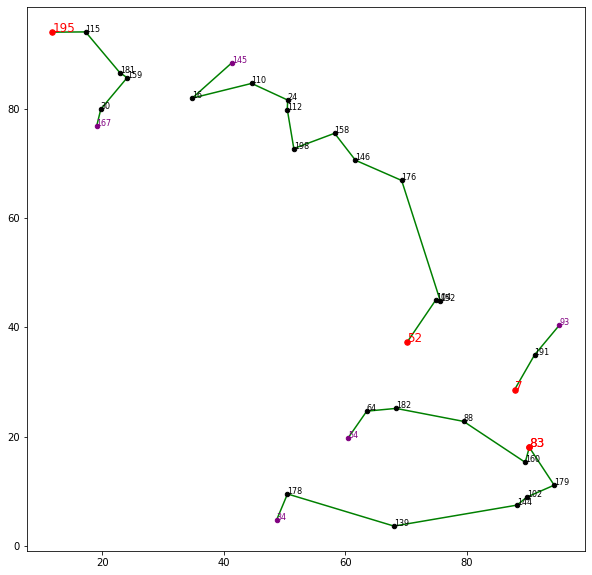

In [14]:
plt.figure(figsize=(10,10))
routes = {x:{} for x in veiculos.index}  
#Cria novamente as rotas de cada veículo
for i in _Solution:
        aux = i.split("_")[1:]
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        
atendimentos = {}
arc_count = {}
for k in veiculos.index:
    #Só roda o código se o veículo tiver percorrido pelo menos um arco
    if len(routes[k]) > 0:
        
        inicial = veiculos.loc[k]["Inicial"]
        actual_node = routes[k].pop(inicial)
        
        #Coordenadas X e Y dos pontos que formam o arco
        xcoord=[pontos.loc[inicial]["x"],pontos.loc[actual_node]["x"]]
        ycoord=[pontos.loc[inicial]["y"],pontos.loc[actual_node]["y"]]
        
        #Plotagem gráfica do arco 
        plt.scatter(xcoord[0],ycoord[0],s=30,color='red',zorder=1)
        plt.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="red")
        plt.plot(xcoord,ycoord,'g',zorder=0)
        
        #String para plotar o caminho que o carro percorreu
        string=str(k)+": "+str(inicial)+" -> "+str(actual_node)
        
        #Garante que o caminho será plotado mesmo se só tiver um arco
        if len(routes[k]) == 0:
            #Plotagem gráfica do último arco do caminho
            plt.scatter(xcoord[1],ycoord[1],s=30,color='black',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(actual_node),fontsize=8,color="black")
        else:
            while actual_node not in vitimas["Ponto"].values:
                next_node = routes[k].pop(actual_node)

                #Adiciona um arco na string
                string+="-> "+str(next_node)

                #Coordenadas X e Y dos pontos que formam o arco
                xcoord=[pontos.loc[actual_node]["x"],pontos.loc[next_node]["x"]]
                ycoord=[pontos.loc[actual_node]["y"],pontos.loc[next_node]["y"]]
                
                #Plotagem gráfica do arco 
                plt.scatter(xcoord[0],ycoord[0],s=20,color='black',zorder=1)
                plt.text(xcoord[0],ycoord[0],str(actual_node),fontsize=8)
                plt.plot(xcoord,ycoord,'g',zorder=0)
                
                actual_node=next_node
            
            #Plotagem gráfica do último arco do caminho
            plt.scatter(xcoord[1],ycoord[1],s=20,color='purple',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(next_node),fontsize=8,color='purple')
            
        atendimentos[k] = actual_node
        print(string)
        
plt.show()

# Sinais

In [128]:
estado = pd.read_csv("s_200",index_col=0)

In [129]:
sinais = Model("Sinais")

In [130]:
sinal = 0 #Tempo entre as alterações de estado de um sinal
for i in pontos.index:
    for j in pontos.loc[i][2:]:
        #Somamos o tempo de cada arco
        sinal+=_DistanceMatrix.loc[i][j]
sinal = (sinal/(3*len(pontos))) #O tempo de alteração vai ser a média

In [131]:
ordered_routes = mt.DecomposeRoute(_Solution,veiculos,vitimas) #Organiza os caminhos por ambulância

In [132]:
arc_time = arc_states = arc_moment = arc_priority = arc_count = {}

In [133]:
def makeArcs(ordered_routes,_DistanceMatrix,veiculos,vitimas,atendimento,pontos,estado,sinal):
    arc_count = {}
    arc_time = {}
    arc_states = {}
    arc_moment={}
    arc_priority = {}
    arc_count = {}

    for k in range(len(ordered_routes)):
        soma_tempo=0
        moment = 0
        
        for i in range(len(ordered_routes[k])-1):
            saida = ordered_routes[k][i]
            chegada = ordered_routes[k][i+1]
            
            soma_tempo+=_DistanceMatrix.loc[saida][chegada]
            
            index_position = pontos.loc[saida][2:][pontos.loc[saida][2:] == chegada].index[0]

            state,moment = mt.getStateAtMoment(estado.loc[saida][index_position],
                                 _DistanceMatrix.loc[saida][chegada],
                                 sinal,moment)
            
            if (saida,chegada) not in list(arc_count.keys()):
                arc_count[(saida,chegada)]= [k]
            else:
                arc_count[(saida,chegada)].append(k)
            
            if (saida,chegada) not in arc_time.keys():
                arc_time[(saida,chegada)] = soma_tempo
                arc_moment[(saida,chegada)] = moment
                arc_states[(saida,chegada)] = state
            
            elif arc_time[(saida,chegada)]<soma_tempo:
                arc_time[(saida,chegada)] = soma_tempo
                arc_moment[(saida,chegada)] = moment
                arc_states[(saida,chegada)] = state
        
            priority = vitimas[vitimas["Ponto"] == atendimento[k]]["Prioridade"].values[0]
            
            if (saida,chegada) not in arc_priority.keys():
                arc_priority[(saida,chegada)] = priority

            elif arc_priority[(saida,chegada)] > priority:
                arc_priority[(saida,chegada)] = priority

        
    return arc_time,arc_states,arc_moment,arc_priority,arc_count

In [134]:
arc_time, arc_states, arc_moment, arc_priority, arc_count = makeArcs(ordered_routes, #Caminhos organizados
                                                                        _DistanceMatrix, #Matriz de Distâncias
                                                                        veiculos,#Instância de veículos
                                                                        vitimas, #Instância de vítimas
                                                                        atendimentos, #Relação Ambulância-Vítima
                                                                        pontos, #Arcos que saem de cada vértice
                                                                        estado, #Estado dos Sinais no tempo 0
                                                                        sinal) #Tempo de alteração do Sinal

arc_closed_moment = {}
for i in arc_moment:
    r=arc_moment[i]%2
    aux = round(arc_moment[i]/2)
    
    #0: Fechado, 1: Aberto
    #0->1->0->1->0...
    if arc_states[i] == False:
        arc_closed_moment[i]=aux+r
        
    #1->0->1->0->1...    
    else:
        arc_closed_moment[i]=aux
    

In [135]:
def buildSets(rota_k,sinal,prioridade,pontos,estado,nodo=0,instante=0,maior_instante=0,sinais_alterados=[],matriz_sinais=[]):
    
    if nodo == (len(rota_k)-1):
        #Configuração atual de sinais
        config_atual={}
        
        #Soma dos pesos dessa configuração
        peso_rota=0
        
        for i in sinais_alterados:
            arco = i["arco"]         #<-(saida,chegada)
            alterado = i["alterado"] #<-(0,1)
            instante = i["instante"] #<-(t)
            peso = i["peso"]         #<-Wij

            
            #Adiciona (saida,chegada):{0/1,t} na matriz de sinais
            #                    0=Não alterado
            #                    1=Alterado
            #                    t=Instante
            config_atual[arco]=(alterado,instante)
            
            #Adiciona o peso do arco atual ao peso total da rota
            peso_rota+=peso
        
        #Multiplica o peso da rota 
        #pelo instante de chegada na vítima
        peso_rota*=i["peso"]
            
        #Adiciona a configuração atual de sinais e o peso correspondente
        #à matriz de configurações para a rota atual
        matriz_sinais.append({"sinais":config_atual,"peso":peso_rota})
        
        #Retorna a matriz de sinais, agora
        #com a configuração atual de sinais
        return matriz_sinais,maior_instante
    
    else:
        #Nodo de saída do arco
        saida = rota_k[nodo]
        #Nodo de chegada do arco
        chegada = rota_k[nodo+1]
        
        #Custo básico 
        custo = _DistanceMatrix.loc[saida][chegada]
        
        #Esse trecho pega o índice do nodo de chegada
        #para verificar o estado do arco (saida,chegada)
        index = pontos.loc[saida][2:][pontos.loc[saida][2:] == chegada].index[0]
        base = estado.loc[saida][index]
        
        #Se o estado do sinal for alterado, 
        #pagamos uma penalidade
        alfa=(3*sinal)/(prioridade) 
        """Apagar esse +1 depois de gerar nova instância"""
        
        estado1,instante1 = mt.getStateAtMoment(base,custo,sinal,instante)
        #                     {estado1=0, se ligado no instante   }
        #             estado1={estado1=1, se desligado no instante}
        #               |
        #               v                       ------------------
        peso1 = custo+estado1*sinal# <- sinal = {tempo pra o sinal}
        #                                       {mudar de estado  }
        #                                       -------------------
        #
        # Se estado1=0 -> estado1*sinal=sinal, então pagamos o custo de esperar no sinal
        # Se estado1=1 -> estado1*sinal=0, o sinal está verde e não precisamos esperar
        
        estado2,instante2 = mt.getStateAtMoment(base,custo+sinal,sinal,instante)
        #                                ----------------------
        #                                {Negação do estado2  }
        #                    (1-estado2)={Se estado2=0, vira 1}
        #                         |      {Se estado2=1, vira 0}
        #                         |       ---------------------
        #                         v                        ------------------
        peso2 = custo+alfa+(1-estado2)*sinal # <- sinal = {tempo pra o sinal}
        #               ^                                 {mudar de estado  }
        #               |    -----------------            ------------------
        #             alfa = {Penalidade por }            
        #                    {alterar o sinal}
        #                    ----------------
        # Se (1-estado2)=1 -> (1-estado2)*sinal=0, então pagamos o custo de esperar no sinal
        # Se (1-estado2)=0 -> (1-estado2)*sinal=sinal, o sinal está verde e não precisamos esperar
        
        if len(sinais_alterados) == 0:
            sinais1=[{"arco":(saida,chegada),"alterado":0,"peso":peso1,"instante":instante1}]
            sinais2=[{"arco":(saida,chegada),"alterado":1,"peso":peso2,"instante":instante2}]
        else:

            sinais1 = sinais_alterados.copy()
            sinais2 = sinais_alterados.copy()
            
            sinais1.append({"arco":(saida,chegada),"alterado":0,"peso":peso1,"instante":instante1})
            sinais2.append({"arco":(saida,chegada),"alterado":1,"peso":peso2,"instante":instante2})
            
        #Esse trecho vai garantir que
        #a gente vai receber no final
        #o maior instante, necessário
        #para criarmos a matriz de de-
        #cisão do mesmo tamanho.
        if instante1 > maior_instante:
            maior_instante = instante1
            
        elif instante2 > maior_instante:
            maior_instante=instante2
        
        
        #A intenção desse programa é popular
        #primeiro por profundidade
        
        matriz_sinais, maior_instante = buildSets(rota_k,sinal,prioridade,pontos,estado,nodo+1,instante1,maior_instante,sinais1,matriz_sinais)
        # Comportamento esperado:
        #                       
        #               o
        #              / \
        #             o aberto
        #            / \
        # Entrando<-x  aberto
        #          /
        #        ...
        # matriz_sinais->matriz_sinais + configuração 1

        matriz_sinais, maior_instante = buildSets(rota_k,sinal,prioridade,pontos,estado,nodo+1,instante2,maior_instante,sinais2,matriz_sinais)
        # Comportamento esperado:
        #            o
        #           / \
        #          o
        #         / \
        # Saiu <-v  x->Entrando
        #       /
        #     ...
        # matriz_sinais->matriz_sinais + configuração 1 + configuração 2
        
        
        return matriz_sinais,maior_instante

In [136]:
maior_instante = 0
matriz_rotas={k:[] for k in atendimentos}
for k in atendimentos:
    prioridade=vitimas[vitimas["Ponto"]==atendimentos[k]]["Prioridade"].values[0]
    matriz,instante=buildSets(ordered_routes[k],sinal,prioridade,pontos,estado,sinais_alterados=[],matriz_sinais=[])
    if instante>maior_instante:
        maior_instante=instante
    matriz_rotas[k] = matriz

In [137]:
same_instant={}

for arc in arc_count:
    same_instant[arc]={}
    instants={}
    for k in atendimentos:
        
        count = 0
        if arc in matriz_rotas[k][count]["sinais"].keys():
            instants[arc]=[]
            while count < len(matriz_rotas[k]):
                instant_k = matriz_rotas[k][count]["sinais"][arc][1]

                if instant_k not in instants[arc]:
                    instants[arc].append(instant_k)
                    same_instant[arc][instant_k]=[(k,count)]
                else:
                    same_instant[arc][instant_k].append((k,count))
                count+=1

In [138]:
config = {}
for k in atendimentos:
    count=0
    config[k]=[]
    for i in matriz_rotas[k]:
        config[k].append({"Config":sinais.binary_var("Config_"+str(count)+"_Carro_"+str(k)),"Peso":i["peso"]})
        count+=1

In [139]:
minimize=LinearExpr(sinais)
for k in atendimentos:
    choose1=LinearExpr(sinais)
    for i in config[k]:
        choose1+=i["Config"]
    sinais.add_constraint(choose1==1,"Choose1ConfigVehicle"+str(k))
sinais.minimize(minimize)

In [140]:
for arc in same_instant:
    for time in same_instant[arc]:
        expressions={}
        for i in same_instant[arc][time]:
            vehicle = i[0]
            config_number = i[1]
            if i[0] not in expressions.keys():
                expr=LinearExpr(sinais)

                expr+=config[vehicle][config_number]["Config"]
                expressions[vehicle]=expr
            else:
                expressions[vehicle]+=config[vehicle][config_number]["Config"]

        consistent_timing=LinearExpr(sinais)
        count=0
        for k in expressions:
            if count==0:
                consistent_timing+=(len(expressions)-1)*expressions[k]
                count+=1
            else:
                consistent_timing-=expressions[k]
        sinais.add_constraint(consistent_timing==0,"ConsistentTimingArc_"+str(arc)+"_Time_"+str(time))

In [141]:
sinais.export_as_lp("ModeloSinais")

'ModeloSinais.lp'

In [142]:
_Solution2 = sinais.solve()

In [150]:
for i in _Solution2.as_dict():
    carro = i.split("_")[3]
    config = i.split("_")[1]
    print(str(carro)+" -> "+str(matriz_rotas[int(carro)][int(config)]["sinais"]))
    print("\n")

0 -> {(83, 179): (0, 1), (179, 102): (0, 3), (102, 144): (0, 4), (144, 139): (0, 7), (139, 178): (0, 10), (178, 34): (0, 12)}


2 -> {(195, 115): (0, 1), (115, 181): (0, 3), (181, 159): (0, 4), (159, 30): (0, 6), (30, 167): (0, 7)}


7 -> {(7, 191): (0, 1), (191, 93): (0, 3)}


9 -> {(83, 160): (0, 0), (160, 88): (0, 2), (88, 182): (0, 4), (182, 64): (0, 6), (64, 54): (0, 8)}


11 -> {(52, 104): (0, 1), (104, 152): (0, 2), (152, 176): (0, 5), (176, 146): (0, 7), (146, 158): (0, 9), (158, 198): (0, 11), (198, 112): (0, 13), (112, 24): (0, 14), (24, 110): (0, 16), (110, 16): (0, 18), (16, 145): (0, 20)}




In [125]:
plt.figure(figsize=(10,10))
routes = {x:{} for x in veiculos.index}  
routes2= []
for i in _Solution:
        aux = i.split("_")[1:]
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        
for i in _Solution2.as_dict():
        aux = i.split("_")[1:]
        routes2.append((int(aux[0]),int(aux[1])))
        
atendimentos = {}
arc_count = {}
for k in veiculos.index:
    if len(routes[k]) > 0:
        
        inicial = veiculos.loc[k]["Inicial"]
        actual_node = routes[k].pop(inicial)
        
       
        xcoord=[pontos.loc[inicial]["x"],pontos.loc[actual_node]["x"]]
        ycoord=[pontos.loc[inicial]["y"],pontos.loc[actual_node]["y"]]
        
        if (inicial,actual_node) in routes2:
            plt.scatter(xcoord[0],ycoord[0],s=30,color='red',zorder=1)
            plt.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="red")
            plt.plot(xcoord,ycoord,'g',zorder=0)
        else:
            plt.scatter(xcoord[0],ycoord[0],s=30,color='red',zorder=1)
            plt.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="red")
            plt.plot(xcoord,ycoord,'black',zorder=0)
        
        if len(routes[k]) == 0:
            plt.scatter(xcoord[1],ycoord[1],s=30,color='black',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(actual_node),fontsize=8,color="black")
        else:
            while actual_node not in vitimas["Ponto"].values:
                next_node = routes[k].pop(actual_node)

                if (actual_node,next_node) not in list(arc_count.keys()):
                    arc_count[(actual_node,next_node)]= 1
                else:
                    arc_count[(actual_node,next_node)]+= 1
                
                string+="-> "+str(next_node)


                xcoord=[pontos.loc[actual_node]["x"],pontos.loc[next_node]["x"]]
                ycoord=[pontos.loc[actual_node]["y"],pontos.loc[next_node]["y"]]
                
                if (actual_node, next_node) in routes2:
                    plt.scatter(xcoord[0],ycoord[0],s=20,color='g',zorder=1)
                    plt.text(xcoord[0],ycoord[0],str(actual_node),fontsize=8)
                    plt.plot(xcoord,ycoord,'g',zorder=0)
                    
                else:
                    plt.scatter(xcoord[0],ycoord[0],s=20,color='black',zorder=1)
                    plt.text(xcoord[0],ycoord[0],str(actual_node),fontsize=8)
                    plt.plot(xcoord,ycoord,'black',zorder=0)

                actual_node=next_node
                
            plt.scatter(xcoord[1],ycoord[1],s=20,color='purple',zorder=1)
            plt.text(xcoord[1],ycoord[1],str(next_node),fontsize=12,color='purple')
        
plt.show()

ValueError: invalid literal for int() with base 10: 'Carro:0'

<Figure size 720x720 with 0 Axes>